In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import tsunamibayes as tb
from tsunamibayes.gaussian_process_regressor import GPR
from tsunamibayes.fault import ReferenceCurveFault, GaussianProcessFault
from tsunamibayes.multifault import MultiFault
from tsunamibayes.utils import bearing, haversine

In [2]:
# fault_initialization_data = [
#     np.load('flores_data.npz'),
#     np.load(config.fault['walanae_data_path'])
# ]# TODO: This will need to contain dictionaries/arrays to initialize both fault objects.

# fault = [
#     GaussianProcessFault( # The Flores fault uses a GaussianProcessFault
#         bounds=model_bounds,
#         **fault_initialization_data[FAULT.FLORES]
#     ),
#     ReferenceCurveFault( # The Walanae fault uses a ReferenceCurveFault
#         bounds=model_bounds,
#         **fault_initialization_data[FAULT.WALANAE]
#     )
# ]

In [3]:
model_bounds = {
    'lat_min': -10,
    'lat_max': -3,
    'lon_min': 112,
    'lon_max': 124
}
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
flores_data = np.load('flores_data.npz')
fault = GaussianProcessFault( # The Flores fault uses a GaussianProcessFault
    bounds=model_bounds,
    kers={'depth': ker, 'dip': ker, 'strike': ker},
    noise={'depth': 1, 'dip': 1, 'strike': 1},
    **flores_data
)
fault

In [4]:
# %matplotlib notebook

In [5]:
plt.style.use('seaborn')

In [6]:
def convert_lat_lon(lat, lon):
    """Converts latitude and longitude from strings to decimals.
    Proper string form: '8-17-43.21S', '118-43-42.00E' etc.
    """
    latitude = sum(float(x) / 60 ** n for n, x in enumerate(lat[:-1].split('-')))  * (1 if 'N' == lat[-1] else -1)
    longitude = sum(float(x) / 60 ** n for n, x in enumerate(lon[:-1].split('-'))) * (1 if 'E' == lon[-1] else -1)
    return latitude, longitude

In [7]:
# Import and plot flores trench earthquake data
# flores_new = pd.read_excel('/Users/paskett/Downloads/Flores Trench Earthquake data 5-7.2.xlsx')
# flores_new['Unnamed: 2']

## Get the fault data -- latitudes/longitudes and strike data

In [8]:
# Get latitude and longitude of faults.

use_hypo = False # I think the Hypo data is wrong -- everything seems shifted too far left on the Walanae fault.
if not use_hypo:
    flores = pd.read_excel('1820_fault_data/FloresThrustSplit_TableToExcel.xlsx')
    walanae = pd.read_excel('1820_fault_data/WalinaeFaultSplit_TableToExcel.xlsx')
    flores_lats, flores_lons = flores[['CenterLat', 'CenterLong']].to_numpy().T
    walanae_lats, walanae_lons = walanae[['CenterLat', 'CenterLong']].to_numpy().T
else:
    flores = pd.read_excel('1820_fault_data/FloresHypoSegments.xlsx')
    walanae = pd.read_excel('1820_fault_data/WalanaeHypoSegments.xlsx')
    flores_lats, flores_lons = flores[['Lat', 'Long']].to_numpy().T
    walanae_lats, walanae_lons = walanae[['Lat', 'Long']].to_numpy().T

In [9]:
# Get a couple of lat/lon for gauges.
bima_latlon = convert_lat_lon('8-27-43.21S', '118-43-42.00E')
makassar_latlon = convert_lat_lon('5-7-30.27S', '119-27-56.45E')

/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as key

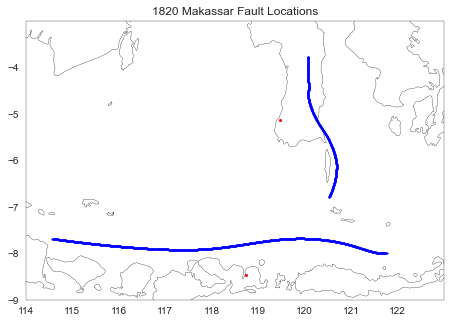

In [10]:
# Plot the fault data.
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(7.5,7))
ax = plt.axes(projection=crs)
ax.set_extent((114,123,-9,-3))
ax.coastlines(resolution='10m')
plt.xticks(np.arange(114,123))
plt.yticks(np.arange(-9,-3))

# Plot the Bima and Makassar gauges.
plt.scatter([bima_latlon[1], makassar_latlon[1]],[bima_latlon[0], makassar_latlon[0]], s=8, c='r')

# Plot the fault data that we already have.
plt.scatter(np.append(flores_lons, walanae_lons), np.append(flores_lats, walanae_lats), s=3, c='b')

plt.title("1820 Makassar Fault Locations")
plt.show()

## Test the ReferenceCurveFault and MultiFault classes on this data

In [11]:
# Get the strike, dip, and depth data needed to initialize ReferenceCurveFaults.
walanae_strikes = walanae['Strike'].to_numpy()
# Dip angle assumed to be 20 degrees.
def walanae_dip(x):
    return np.ones(np.shape(x))*25 

# Depths are assumed to be 20 km.
def walanae_depth(dist):
    """Gives depth based on distance from fault. 
    A negative distance is higher than the base fault depth.
    """
    base_depth = 20000
    extra_depth = dist*np.tan(np.deg2rad(walanae_dip(dist)))
    return base_depth - extra_depth

walanae_bounds = {'lonmin':118, 'lon_max':122, 'lat_min': -7.5, 'lat_max': -3}

# Now do the same for flores fault.
flores_strikes = flores['Strike'].to_numpy()
# "Check for fault plane solutions" ?, we will guess dip of 32.5 degrees
flores_dip = lambda x: np.ones(np.shape(x))*32.5 # FIXME: The dip will be fixed at any point, right?
def flores_depth(dist):
    """Gives depth based on distance from fault. 
    A negative distance is higher than the base fault depth.
    """
    base_depth = 25000 #FIXME: should this be assumed at 25 km also?
    extra_depth = dist*np.tan(np.deg2rad(flores_dip(dist)))
    return base_depth - extra_depth
    
flores_bounds = {'lonmin':114, 'lon_max':123, 'lat_min': -8.5, 'lat_max': -7}

In [12]:
dist = 10000
dist*np.tan(np.deg2rad(walanae_dip(dist)))

4663.076581549986

In [13]:
# np.savez(
#     'walanae_data.npz', 
#     latpts=walanae_lats,
#     lonpts=walanae_lons, 
#     strikepts=walanae_strikes, 
#     depth_curve=walanae_depth, 
#     dip_curve=walanae_dip,
#     bounds=walanae_bounds
# )

In [14]:
# walanae_rcf = ReferenceCurveFault(
#     walanae_lats, 
#     walanae_lons,
#     walanae_strikes, 
#     walanae_depth, 
#     walanae_dip,
#     walanae_bounds)

In [15]:
# Create ReferenceCurveFaults for Walanae and Flores faults.
walanae_rcf = ReferenceCurveFault(
    walanae_lats, 
    walanae_lons,
    walanae_strikes, 
    walanae_depth, 
    walanae_dip,
    walanae_bounds)
flores_rcf = ReferenceCurveFault(
    flores_lats, 
    flores_lons,
    flores_strikes, 
    flores_depth, 
    flores_dip,
    flores_bounds)

In [24]:
# Let's try testing the depths over different latitude and longitude locations.
lats = np.linspace(-9,-7,300)
lons = np.linspace(114,123,100)
X,Y = np.meshgrid(lats, lons)
depths,sides = flores_rcf.depth_map(
    X.flatten()[:,np.newaxis],
    Y.flatten()[:,np.newaxis], 
    True
)

In [25]:
#%matplotlib notebook

Text(0.5, 0.92, 'Depth of Flores Fault (m)')

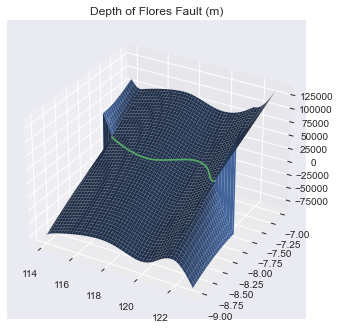

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,depths.reshape(100,300))
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_depth(np.zeros(flores_rcf.latpts.shape)))
plt.title('Depth of Flores Fault (m)')

In [19]:
# Let's try testing the dips over different latitude and longitude locations.
lats = np.linspace(-9,-7,300)
lons = np.linspace(114,123,100)
X,Y = np.meshgrid(lats, lons)
dips = flores_rcf.dip_map(
    X.flatten()[:,np.newaxis],
    Y.flatten()[:,np.newaxis], 
)

Text(0.5, 0.92, 'Dip of Flores Fault')

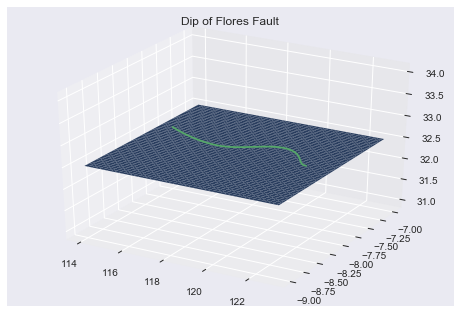

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,dips.reshape(100,300))
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_dip(np.zeros(flores_rcf.latpts.shape)))
plt.title('Dip of Flores Fault')

In [17]:
# Let's try testing the strike over different latitude and longitude locations.
strikes = flores_rcf.strike_map(
    X.flatten()[:,np.newaxis],
    Y.flatten()[:,np.newaxis], 
)

Text(0.5, 0.92, 'Strike of Flores Fault')

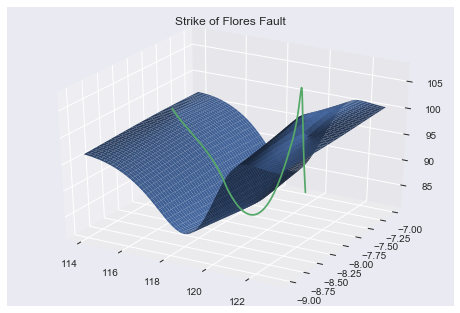

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,strikes.reshape(100,300))
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_strikes)
plt.title('Strike of Flores Fault')

# Try building/testing a MultiFault object

In [19]:
mf = MultiFault([flores_rcf, walanae_rcf], [113, 123, -9, -3])

Text(0.5, 1.0, 'Latitudes and Longitudes to Consider')

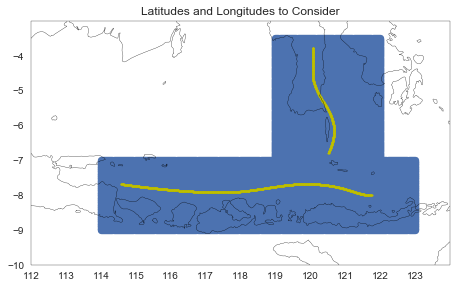

In [20]:
# Build a grid around the Flores fault
lats = np.linspace(-9,-7,100)
lons = np.linspace(114,123,300)
X1,Y1 = np.meshgrid(lats, lons)

# Build a grid around the Walanae fault
lats = np.linspace(-8,-3.5,300)
lons = np.linspace(119,122,100)
X2,Y2 = np.meshgrid(lats, lons)

X1,X2,Y1,Y2 = [x.flatten() for x in (X1,X2,Y1,Y2)]
X = np.append(X1,X2)
Y = np.append(Y1,Y2)

# Plot the geography data.
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(7.5,7))
ax = plt.axes(projection=crs)
ax.set_extent((113,124,-10,-3))
ax.coastlines(resolution='10m')
plt.xticks(np.arange(112,124))
plt.yticks(np.arange(-10,-3))

plt.scatter(Y,X)
plt.scatter(np.append(flores_lons, walanae_lons), np.append(flores_lats, walanae_lats), s=3, c='y')
plt.title('Latitudes and Longitudes to Consider')

In [21]:
which_fault = mf._find_closest_fault(X[:,np.newaxis],Y[:,np.newaxis])

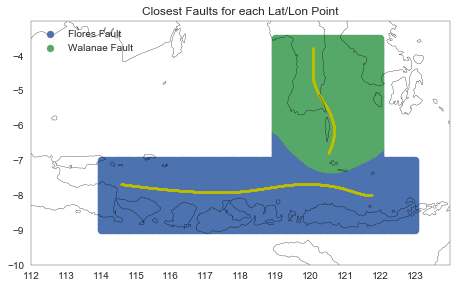

In [22]:
fl = which_fault == 0
wa = which_fault == 1

# Plot the geography data.
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(7.5,7))
ax = plt.axes(projection=crs)
ax.set_extent((113,124,-10,-3))
ax.coastlines(resolution='10m')
plt.xticks(np.arange(112,124))
plt.yticks(np.arange(-10,-3))

# Plot which faults apply where
plt.scatter(Y[fl],X[fl],label='Flores Fault')
plt.scatter(Y[wa],X[wa],label='Walanae Fault')
plt.scatter(np.append(flores_lons, walanae_lons), np.append(flores_lats, walanae_lats), s=3, c='y')
plt.title('Closest Faults for each Lat/Lon Point')
plt.legend()

In [23]:
mfdepth = mf.depth_map(X[:,np.newaxis], Y[:,np.newaxis])

In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


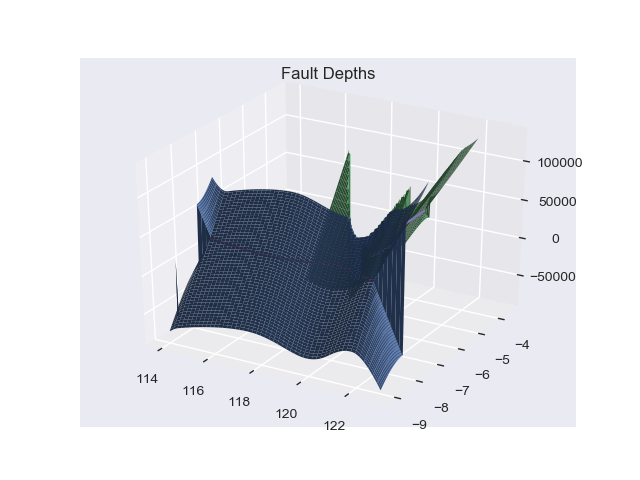

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.plot_surface(Y1.reshape(300,100),X1.reshape(300,100),mfdepth[:30000].reshape(300,100))
# Plot original Walanae-associated lat/lon depths
ax.plot_surface(Y2.reshape(100,300),X2.reshape(100,300),mfdepth[30000:].reshape(100,300))
# Plot both fault lines
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_rcf.depth_curve(np.zeros(flores_rcf.latpts.shape)))
ax.plot(walanae_rcf.lonpts, walanae_rcf.latpts, walanae_rcf.depth_curve(np.zeros(walanae_rcf.latpts.shape)))
plt.title('Fault Depths')
plt.show()

In [26]:
mfdip = mf.dip_map(X[:,np.newaxis], Y[:,np.newaxis])

<IPython.core.display.Javascript object>


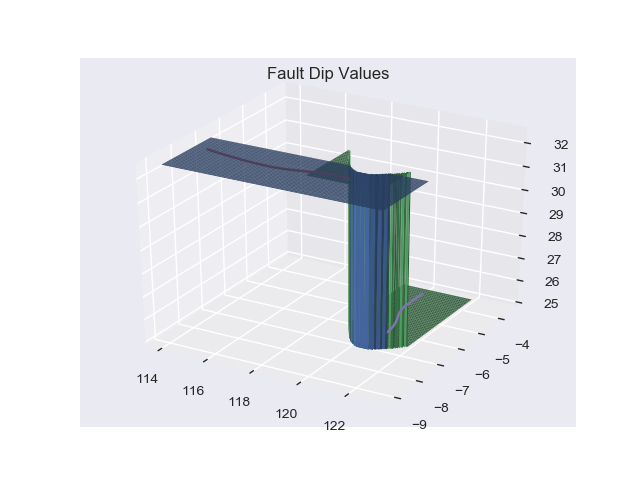

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.plot_surface(Y1.reshape(300,100),X1.reshape(300,100),mfdip[:30000].reshape(300,100))
# Plot original Walanae-associated lat/lon depths
ax.plot_surface(Y2.reshape(100,300),X2.reshape(100,300),mfdip[30000:].reshape(100,300))
# Plot both fault lines
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_rcf.dip_curve(np.zeros(flores_rcf.latpts.shape)))
ax.plot(walanae_rcf.lonpts, walanae_rcf.latpts, walanae_rcf.dip_curve(np.zeros(walanae_rcf.latpts.shape)))
plt.title('Fault Dip Values')
plt.show()

In [28]:
mfstrike = mf.strike_map(X[:,np.newaxis], Y[:,np.newaxis])

<IPython.core.display.Javascript object>


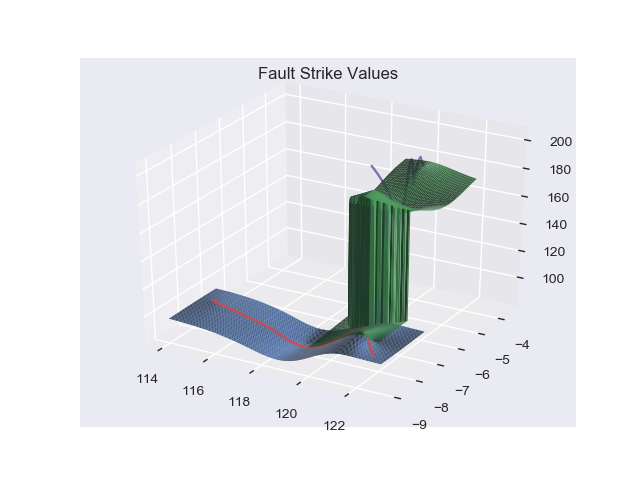

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.plot_surface(Y1.reshape(300,100),X1.reshape(300,100),mfstrike[:30000].reshape(300,100))
# Plot original Walanae-associated lat/lon depths
ax.plot_surface(Y2.reshape(100,300),X2.reshape(100,300),mfstrike[30000:].reshape(100,300))
# Plot both fault lines
ax.plot(flores_rcf.lonpts, flores_rcf.latpts, flores_rcf.strikepts)
ax.plot(walanae_rcf.lonpts, walanae_rcf.latpts, walanae_rcf.strikepts)
plt.title('Fault Strike Values')
plt.show()

In [36]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [101]:
choices = np.random.choice(np.arange(len(flores_lons)), 15, replace=False)
lats = flores_lats[choices]
lons = flores_lons[choices]
X = np.vstack([lats, lons]).T
y = flores_depth(np.zeros(15)) + 1000*np.random.randn(15)

In [102]:
# If we have a specific covariance that we believe in, we could use that as
# the kernel for the GaussianProcessRegressor, but I don't know of one.
# The best one I can think of is to have high covariances for nearby points and 
# lower ones for far away points, perhaps at a quadratic rate.
gpr = GaussianProcessRegressor(n_restarts_optimizer=12)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gpr.predict(
    np.vstack([flores_lats, flores_lons]).T, 
    return_std=True
)

/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [103]:
Xplot, Yplot = np.meshgrid(flores_lons,flores_lats)
Zplot = gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T).reshape(Xplot.shape)

<IPython.core.display.Javascript object>


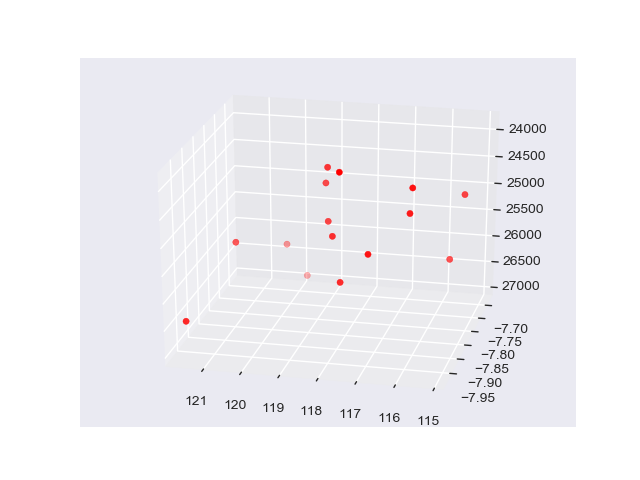

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)

<IPython.core.display.Javascript object>


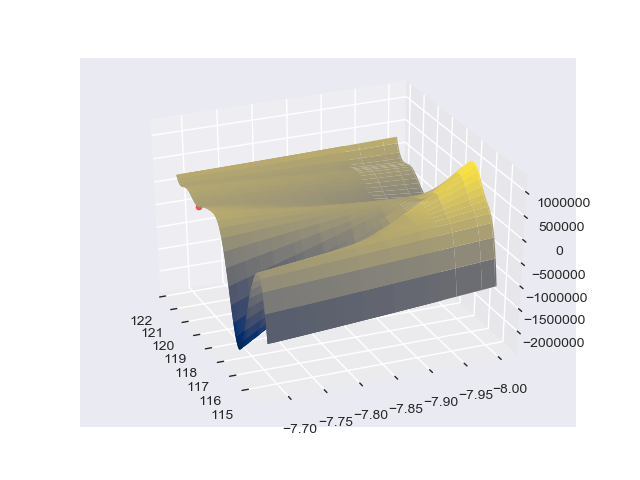

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)

In [111]:
gpr.log_marginal_likelihood_value_

-365983787037160.1

In [112]:
gpr.kernel_

1**2 * RBF(length_scale=1)